<a href="https://colab.research.google.com/github/georgezefko/Twitter-Sentiment-Analysis/blob/main/LSTM_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk import sent_tokenize
from sklearn.utils import resample
import unicodedata
import string
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
train_data = '/content/drive/MyDrive/disaster_tweet/'
train = pd.read_csv(train_data+'train.csv')
test = pd.read_csv(train_data+'test.csv')

In [12]:
#save only the text and target data drop the unnecessary columns
train = train.drop(['id','keyword','location'], axis=1)
test = test.drop(['id','keyword','location'], axis=1)

In [5]:
STOPWORDS = nltk.corpus.stopwords.words('english')

def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\b\w\b', ' ', text)
    text = re.sub('@[^\s]+','',text)
    text = emoji_pattern.sub(r'', text)       
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS if len(word)>=3) # remove stopwords from text

    return text


def tokenize(text):
  tokens = nltk.word_tokenize(text)
  return tokens

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  lem_list = [lemmatizer.lemmatize(word) for word in text]
  return lem_list

def rejoin_words(text):
  joined_words = (" ".join(text))
  return joined_words

In [13]:
train['text']=train['text'].apply(clean_text)
train['text']=train['text'].apply(tokenize)
train['text']=train['text'].apply(lemmatize)
train['text']=train['text'].apply(rejoin_words)

In [14]:
train_sentences = train['text'].values
train_labels = train['target'].values

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_sentences, train_labels, test_size=0.2)

In [16]:
maxLen = len(max(X_train, key=len).split())

In [17]:
maxLen

21

In [18]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [19]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/disaster_tweet/glove.6B.50d.txt')

In [20]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          if w not in word_to_index: #needs to be fixed
              w = 'unk'
            # Set the (i,j)th entry of X_indices to the index of the correct word.
          X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
          j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

In [21]:
X1 = np.array(["funny lol", "lets play baseball siouxlan", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball siouxlan' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714. 372306.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [22]:
X2 = X_train[2:4]
X2_indices = sentences_to_indices(X2,word_to_index, maxLen )
print("X1 =", X2)
print("X1_indices =\n", X2_indices)

X1 = ['every bts song jimin scream'
 'new type adhd head injury child linked long term attention problem']
X1_indices =
 [[141941.  85744. 337465. 197746. 322154.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]
 [259972. 368669.  46435. 175207. 190227.  98970. 223138. 225289. 356157.
   62719. 292794.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]]


In [23]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [24]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [25]:
def tweet_classifier(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(1)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    ### END CODE HERE ###
    
    return model

In [26]:
model = tweet_classifier((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 21, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 256)           183296    
_________________________________________________________________
dropout (Dropout)            (None, 21, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240

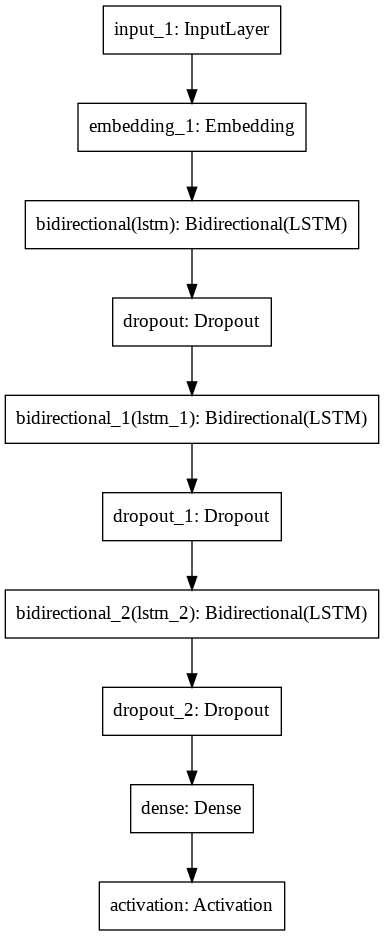

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen )
X_valid_indices = sentences_to_indices(X_valid, word_to_index, maxLen )


In [35]:
history = model.fit(X_train_indices, y_train, epochs = 50, batch_size = 32,shuffle=True, validation_data=(X_valid_indices, y_valid))

Epoch 1/50
191/191 [==============================] - 48s 250ms/step - loss: 0.3934 - accuracy: 0.8315 - val_loss: 0.4443 - val_accuracy: 0.8162
Epoch 2/50
191/191 [==============================] - 45s 236ms/step - loss: 0.3726 - accuracy: 0.8427 - val_loss: 0.4691 - val_accuracy: 0.7984
Epoch 3/50
191/191 [==============================] - 43s 226ms/step - loss: 0.3574 - accuracy: 0.8452 - val_loss: 0.4598 - val_accuracy: 0.8102
Epoch 4/50
191/191 [==============================] - 45s 233ms/step - loss: 0.3372 - accuracy: 0.8631 - val_loss: 0.4595 - val_accuracy: 0.8109
Epoch 5/50
191/191 [==============================] - 45s 235ms/step - loss: 0.3168 - accuracy: 0.8727 - val_loss: 0.4729 - val_accuracy: 0.8063
Epoch 6/50
191/191 [==============================] - 45s 235ms/step - loss: 0.2892 - accuracy: 0.8852 - val_loss: 0.5054 - val_accuracy: 0.8063
Epoch 7/50
191/191 [==============================] - 45s 233ms/step - loss: 0.2754 - accuracy: 0.8916 - val_loss: 0.5350 - val_ac

In [36]:
X_test_indices = sentences_to_indices(X_valid, word_to_index, max_len = 21 )

loss, acc = model.evaluate(X_test_indices, y_valid)
print()
print("Test accuracy = ", acc)

48/48 [==============================] - 3s 58ms/step - loss: 1.2614 - accuracy: 0.7827

Test accuracy =  0.7826657891273499


In [37]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

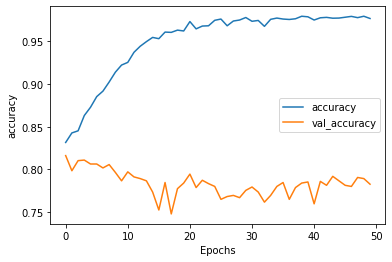

In [38]:
plot_graphs(history,'accuracy')

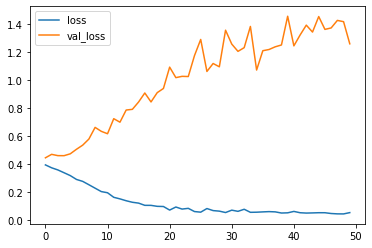

In [40]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [41]:
test['text']=test['text'].apply(clean_text)
test['text']=test['text'].apply(tokenize)
test['text']=test['text'].apply(lemmatize)
test['text']=test['text'].apply(rejoin_words)
test_sentences = test['text'].values

In [42]:
maxLen = len(max(test_sentences, key=len).split())
X_test_indices = sentences_to_indices(test_sentences, word_to_index, 21)
y = model.predict(X_test_indices).round()
y_final = y.astype(int)

In [43]:
X_test_indices

array([[173063., 356326.,  91624., ...,      0.,      0.,      0.],
       [175426., 132523., 123767., ...,      0.,      0.,      0.],
       [151580., 148728., 340109., ...,      0.,      0.,      0.],
       ...,
       [166484., 222946., 121383., ...,      0.,      0.,      0.],
       [239818., 193637., 175016., ...,      0.,      0.,      0.],
       [372306.,  45856., 252973., ...,      0.,      0.,      0.]])

In [44]:
y_final

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [45]:
pred = pd.DataFrame(y_final,columns=['target'])

In [46]:
pred['target'].value_counts()

0    1973
1    1290
Name: target, dtype: int64

In [47]:
sample_submission = pd.read_csv('/content/drive/MyDrive/disaster_tweet/sample_submission.csv')
sample_submission['target'] = pred

In [48]:
sample_submission['target'].head(20)

0     1
1     1
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    0
14    0
15    1
16    0
17    0
18    0
19    0
Name: target, dtype: int64

In [49]:

submission_4 = sample_submission.to_csv('submission_4.csv', index=False)


In [50]:
sample_ = pd.read_csv('/content/submission_4.csv')


In [51]:
sample_.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
